In [1]:
%matplotlib notebook
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import plyfile
import pandas
from importlib import reload
import cv2
from scipy.ndimage.filters import gaussian_filter1d
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from speed_regression import training_data as td
from speed_regression import regression
from speed_regression import regression_cascade
nano_to_sec = 1e09

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 10

In [2]:
option = td.TrainingDataOption()
extra_args = {'feature_smooth_sigma': 2.0,
              'target_smooth_sigma': 30.0}
imu_columns = ['gyro_x', 'gyro_y', 'gyro_z', 'linacce_x', 'linacce_y', 'linacce_z']

In [3]:
model_path = '../../models/svr_cascade1108'
model = regression_cascade.load_model_from_file(model_path)

# num_sv_classifier = model.classifier.getSupportVectors().shape[0]
# num_sv_regressor = [reg.getSupportVectors().shape[0] for reg in model.regressors]
# print('Number of supporting vectors: {}, {}'.format(num_sv_classifier, num_sv_regressor))
# print('Total number of sv: ', num_sv_classifier + sum(num_sv_regressor))
print('Class map: ', model.class_map)

Class map:  {'bag': 2, 'body': 3, 'transition': 4, 'leg': 1, 'handheld': 0}


In [29]:
# load testing data
train_feature, train_label, train_responses, _ = regression_cascade.load_datalist('../../data2/list_train_1031.txt',
                                                                                 option, model.class_map)

train_responses = train_responses[:, [0, 2]]

Loading dataset ../../data2/hang_handheld_speed1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_side1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_spin1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_stop1/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_leg_front1/processed/data.csv, type: leg
Loading dataset ../../data2/hang_leg_front2/processed/data.csv, type: leg
Loading dataset ../../data2/hang_bag_normal1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_speed1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_side1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_spin1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_stop1/processed/data.csv, type: bag
Loading dataset ../../data2/hang_body_backward1/processed/data.csv, type: body
Loading dataset ../../data2/hang_body_backward3/processed/data.csv, type

In [58]:
test_feature, test_label, test_responses, _ = regression_cascade.load_datalist('../../data2/list_test_allsub.txt',
                                                                              option, model.class_map)
test_responses = test_responses[:, [0, 2]]
feature_classes = [test_feature[test_label==cls].astype(np.float32)
                   for cls in model.class_map.values()]
response_classes = [test_responses[test_label==cls].astype(np.float32)
                    for cls in model.class_map.values()]

Loading dataset ../../data2/hang_handheld_normal2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_speed2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_side2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_handheld_spin2/processed/data.csv, type: handheld
Loading dataset ../../data2/hang_body_backward2/processed/data.csv, type: body
Loading dataset ../../data2/hang_leg_front3/processed/data.csv, type: leg
Loading dataset ../../data2/hang_bag_normal2/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_speed2/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_side2/processed/data.csv, type: bag
Loading dataset ../../data2/hang_bag_spin2/processed/data.csv, type: bag
Loading dataset ../../data2/huayi_handheld2/processed/data.csv, type: handheld
Loading dataset ../../data2/huayi_leg2/processed/data.csv, type: leg
Loading dataset ../../data2/yajie_handheld2/processed/data.csv, type:

In [9]:
# Test with the baseline model
channel_list = [0, 2]
predicted_all = [[], []]
gt_all = [[], []]
time_for_testing = 0
for i in range(2):
    regressor = cv2.ml.SVM_load('../../models/SVR_allinone_1023_w200_s10_{}.yml'.format(channel_list[i]))
    print('Model loaded')
    t = time.time()
    for cls in model.class_map.values():
        predicted = regressor.predict(feature_classes[cls])[1].ravel()
        # r2 = r2_score(predicted, response_classes[cls][:, chn])
        mse = mean_squared_error(predicted, response_classes[cls][:, i])
        print('Baseline, class %d, channel %d, score: %f(MSE)' % (cls, i, mse))
        predicted_all[i].append(predicted)
        gt_all[i].append(response_classes[cls][:, i])
    time_for_testing += time.time() - t
for i in range(2):
    predicted_all[i] = np.concatenate(predicted_all[i], axis=0)
    gt_all[i] = np.concatenate(gt_all[i], axis=0)
    mse = mean_squared_error(predicted_all[i], gt_all[i])
    print('Overall regression error for channel %d: %f(MSE)' % (i, mse))
print('Time usage: ', time_for_testing)

Model loaded
Baseline, class 1, channel 0, score: 0.020586(MSE)
Baseline, class 0, channel 0, score: 0.020788(MSE)
Baseline, class 3, channel 0, score: 0.041892(MSE)
Baseline, class 2, channel 0, score: 0.006795(MSE)
Model loaded
Baseline, class 1, channel 1, score: 0.028263(MSE)
Baseline, class 0, channel 1, score: 0.013092(MSE)
Baseline, class 3, channel 1, score: 0.045071(MSE)
Baseline, class 2, channel 1, score: 0.013720(MSE)
Overall regression error for channel 0: 0.022995(MSE)
Overall regression error for channel 1: 0.024688(MSE)
Time usage:  255.67447972297668


In [12]:
## Training error
t = time.time()
print('Training error')
label_predicted_on_train, response_predicted_on_train = model.test(train_feature, train_label, train_responses)
print('Time usage: ', time.time() - t)

Training error
Classification accuracy:  0.907179814093
Error for class 1, channel 0: 0.113370(MSE)
Error for class 1, channel 1: 0.144594(MSE)
Error for class 2, channel 0: 0.030945(MSE)
Error for class 2, channel 1: 0.020930(MSE)
Error for class 3, channel 0: 0.013872(MSE)
Error for class 3, channel 1: 0.028358(MSE)
Error for class 0, channel 0: 0.048855(MSE)
Error for class 0, channel 1: 0.038109(MSE)
Overall regression error for channel 0: 0.888635(R2), 0.043260(MSE)
Overall regression error for channel 1: 0.885887(R2), 0.050410(MSE)
Time usage:  88.85662341117859


In [59]:
# Testing error
t = time.time()
print('Testing error')
label_predicted, response_predicted = model.test(test_feature, test_label, test_responses)
print('Time usage: ', time.time() - t)

Testing error
Classification accuracy:  0.935985844024
Error for class 2, channel 0: 0.012698(MSE)
Error for class 2, channel 1: 0.013418(MSE)
Error for class 3, channel 0: 0.006101(MSE)
Error for class 3, channel 1: 0.009952(MSE)
Error for class 0, channel 0: 0.019848(MSE)
Error for class 0, channel 1: 0.018182(MSE)
Error for class 1, channel 0: 0.016263(MSE)
Error for class 1, channel 1: 0.007215(MSE)
Overall regression error for channel 0: 0.949392(R2), 0.016617(MSE)
Overall regression error for channel 1: 0.968451(R2), 0.017135(MSE)
Time usage:  272.4959638118744


In [18]:
# Compute the confusion matrix. 
# confusion_matrix[i, j] means the number of samples with the class i predicted as the class j.
num_classes = model.num_classes
confusion_matrix = np.zeros([num_classes, num_classes], dtype=np.int)
for i in range(label_predicted.shape[0]):
    confusion_matrix[test_label[i], int(label_predicted[i])] += 1
print('Class map: ', model.class_map)
print(confusion_matrix)
# The classification accuracy is the sum of the diagonal elements divided by the sum of the whole matrix. Make sure
# this number matches the testing accuracy.
accuracy = np.sum(np.diagonal(confusion_matrix).astype(np.float)) / np.sum(confusion_matrix).astype(np.float)
print('Accuracy: ', accuracy)

# # Draw the confusion matrix
# confusion_matrix = confusion_matrix.astype(float) / label_predicted.shape[0]
# print('Confusion_normalized\n', confusion_matrix)

# plt.imshow(confusion_matrix, interpolation='nearest')

Class map:  {'leg': 1, 'bag': 2, 'body': 3, 'handheld': 0, 'transition': 4}
[[14451     0    35   867    46]
 [   24 11584    69   899  1976]
 [    2     1  7965   697   140]
 [   38     0    11  5944     6]
 [    0     0     0     0     0]]
Accuracy:  0.892503630879


In [30]:
# Analyze the model
dummy_feature = test_feature[0, :]
sv_classification = model.classifier.getSupportVectors()
dim = sv_classification.shape[1]

dtype = {'names': ['f{}'.format(i) for i in range(dim)],
        'formats': dim * [sv_classification.dtype]}

num_shared_sv = 0
for cls in range(model.num_classes):
    sum_cls = 0
    for chn in range(model.num_channels):
        sv_regressor = model.regressors[cls * model.num_channels + chn].getSupportVectors()
        inter = np.intersect1d(sv_classification.view(dtype), sv_regressor.view(dtype))
        print('Number of shared SV for class {}, channel {}: {}'.format(cls, chn, inter.shape[0]))
        sum_cls += inter.shape[0]
        num_shared_sv += inter.shape[0]
    print('Shared SV for class {}: {}'.format(cls, sum_cls))
print('Unshared SV: ', sv_classification.shape[0] - num_shared_sv)
print('Total number of shared sv: {:d}, ratio: {:f}'.format(num_shared_sv, num_shared_sv
                                                            / sv_classification.shape[0]))

Number of shared SV for class 0, channel 0: 951
Number of shared SV for class 0, channel 1: 1323
Shared SV for class 0: 2274
Number of shared SV for class 1, channel 0: 2025
Number of shared SV for class 1, channel 1: 2036
Shared SV for class 1: 4061
Number of shared SV for class 2, channel 0: 1226
Number of shared SV for class 2, channel 1: 1151
Shared SV for class 2: 2377
Number of shared SV for class 3, channel 0: 1134
Number of shared SV for class 3, channel 1: 1222
Shared SV for class 3: 2356
Unshared SV:  301
Total number of shared sv: 11068, ratio: 0.973524


In [37]:
model_old = regression_cascade.load_model_from_file('../../models/svr_cascade1023_hang')
model_new = regression_cascade.load_model_from_file('../../models/svr_cascade1023_small')
# model_new = model

In [35]:
# Load a single dataset and plot the speed
data_single = pandas.read_csv('../../data2/shali_bag1/processed/data.csv')
gyro = data_single[['gyro_x', 'gyro_y', 'gyro_z']].values
# plt.figure('gyro')
# plt.plot(gyro[:, 2])

t = data_single['time']
option2 = td.TrainingDataOption(sample_step=20)
# sample_points = np.arange(option.window_size_, t.shape[0] - 1, 50)
feature_single, response_single = td.get_training_data(data_all=data_single, imu_columns=imu_columns,
                                                       option=option2, extra_args=extra_args)
response_single = response_single[:, [0, 2]]

Error for class 0, channel 0: 0.049466(MSE)
Error for class 0, channel 1: 0.716710(MSE)
Error for class 1, channel 0: 0.487771(MSE)
Error for class 1, channel 1: 0.014882(MSE)
Error for class 2, channel 0: 0.112202(MSE)
Error for class 2, channel 1: 0.096747(MSE)
Error for class 3, channel 0: 0.168544(MSE)
Error for class 3, channel 1: 0.011308(MSE)
Overall regression error for channel 0: 0.115654(MSE)
Overall regression error for channel 1: 0.096041(MSE)
Error for class 1, channel 0: 0.132173(MSE)
Error for class 1, channel 1: 0.012302(MSE)
Error for class 2, channel 0: 0.051941(MSE)
Error for class 2, channel 1: 0.039225(MSE)
Error for class 3, channel 0: 0.097120(MSE)
Error for class 3, channel 1: 0.005666(MSE)
Overall regression error for channel 0: 0.056097(MSE)
Overall regression error for channel 1: 0.036518(MSE)


<IPython.core.display.Javascript object>


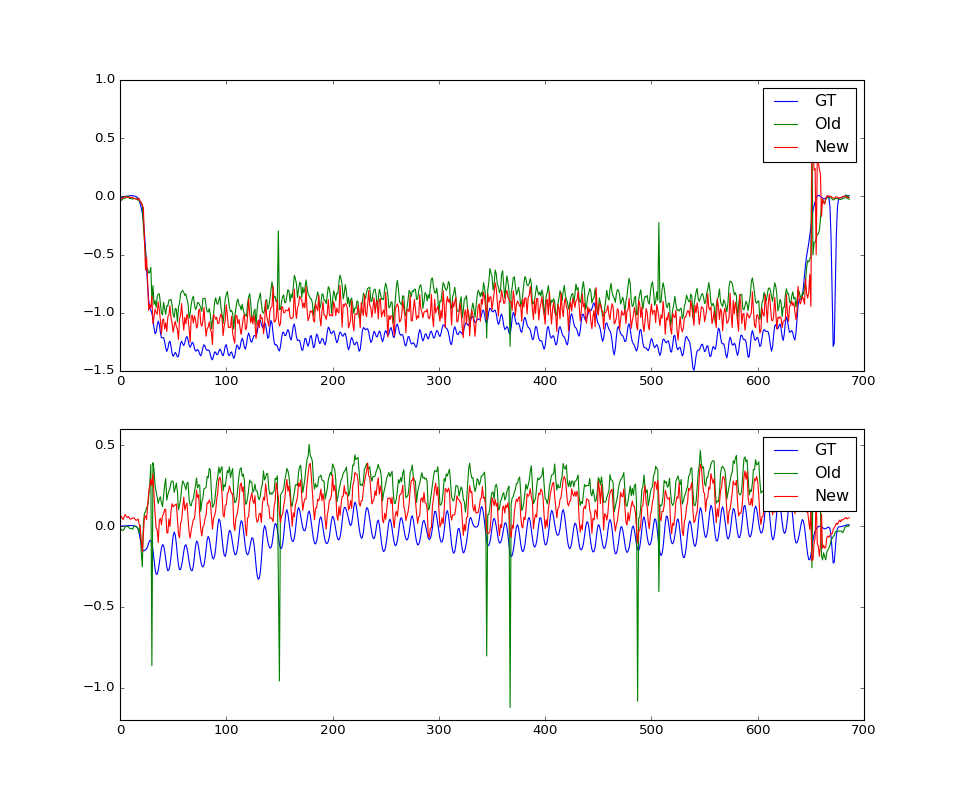

In [38]:
label_old, response_old = model_old.test(feature_single, None, response_single)
label_new, response_new = model_new.test(feature_single, None, response_single)

#plt.figure('Label')
#plt.ylim(-1, 5)
# plt.plot(label_old)
#plt.plot(label_new)
#plt.legend(['Old', 'New'])

plt.figure('Regression')
for i in range(2):
    plt.subplot(211 + i)
    plt.plot(response_single[:, i])
    plt.plot(response_old[:, i])
    plt.plot(response_new[:, i])
    plt.legend(['GT', 'Old', 'New'])

<IPython.core.display.Javascript object>


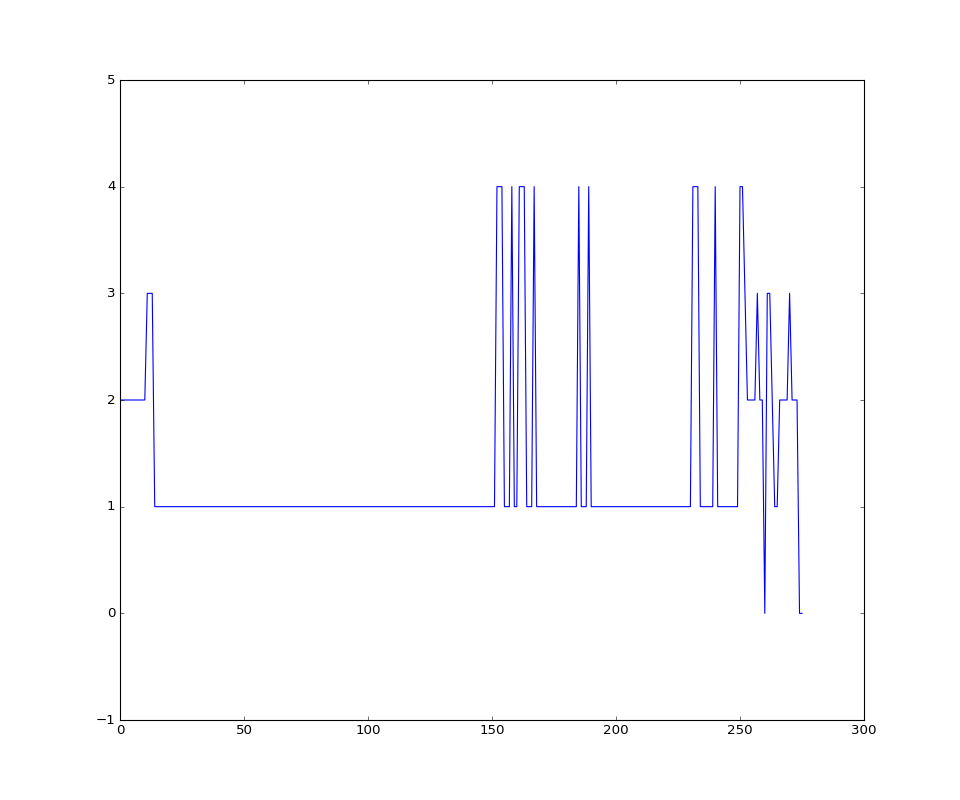

In [51]:
# Experiment with trained classifier
svm = cv2.ml.SVM_load('../../models/svr_cascade1108/classifier.yaml')
predicted_label = svm.predict(feature_single.astype(np.float32))[1].ravel()

# true_label = np.ones(predicted_label.shape[0], dtype=np.int)
# print('Accuracy: ', accuracy_score(y_pred=predicted_label.astype(np.int), y_true=true_label))

plt.figure('Classification')
plt.ylim(-1, 5)
plt.plot(predicted_label)

In [4]:
train_set = np.load('../../data2/train_test_all/train.npy')
feature_train, label_train, response_train = train_set[:, :-3], train_set[:, -3], train_set[:, -2:]
test_set = np.load('../../data2/train_test_all/test.npy')
feature_test, label_test, response_test = test_set[:, :-3], test_set[:, -3], test_set[:, -2:]

In [6]:
label_on_train, response_on_train = model.test(feature_train, label_train.astype(np.int32), response_train)
label_on_test, response_on_test = model.test(feature_test, label_test.astype(np.int32), response_test)

Classification accuracy:  0.946986285583
Error for class 1, channel 0: 0.000185(MSE)
Error for class 1, channel 1: 0.000207(MSE)
Error for class 3, channel 0: 0.000648(MSE)
Error for class 3, channel 1: 0.001679(MSE)
Error for class 2, channel 0: 0.001730(MSE)
Error for class 2, channel 1: 0.000802(MSE)
Error for class 0, channel 0: 0.006943(MSE)
Error for class 0, channel 1: 0.007078(MSE)
Overall regression error for channel 0: 0.002389(MSE)
Overall regression error for channel 1: 0.002513(MSE)
Classification accuracy:  0.936482848887
Error for class 1, channel 0: 0.021145(MSE)
Error for class 1, channel 1: 0.023850(MSE)
Error for class 3, channel 0: 0.003898(MSE)
Error for class 3, channel 1: 0.009548(MSE)
Error for class 2, channel 0: 0.010295(MSE)
Error for class 2, channel 1: 0.006283(MSE)
Error for class 0, channel 0: 0.016348(MSE)
Error for class 0, channel 1: 0.017863(MSE)
Overall regression error for channel 0: 0.011493(MSE)
Overall regression error for channel 1: 0.013127(MSE

In [9]:
# Train a all-in-one model and save it to file
cv_subsample = 6
feature_train_small = feature_train[0:-1:cv_subsample]
response_train_small = response_train[0:-1:cv_subsample]
best_c = [10., 1.]
best_e = [0.001, 0.001]

# search_dict = {'C':[1.0, 10.0],
#               'epsilon':[0.001, 0.01, 0.1]}
# for chn in range(response_train.shape[1]):
#     grid_searcher = GridSearchCV(svm.SVR(), search_dict, n_jobs=6, verbose=3, scoring='neg_mean_squared_error')
#     grid_searcher.fit(feature_train_small, response_train_small[:, chn])
#     best_parameter = grid_searcher.best_params_
#     best_c[chn] = best_parameter['C']
#     best_e[chn] = best_parameter['epsilon']
#     print('Channel %d, best c: %f, best e: %f' % (chn, best_c[chn], best_e[chn]))

output_path = '../../models/SVR_allinone1107'
if not os.path.exists(output_path):
    os.makedirs(output_path)
for chn in range(response_train.shape[1]):
    print('Training for channel %d' % chn)
    option_allinone = regression_cascade.SVMOption(svm_type=cv2.ml.SVM_EPS_SVR, gamma=1./response_train.shape[1], 
                                                   C=best_c[chn], e=best_e[chn])
    svr = regression_cascade.create_svm(option_allinone)
    svr.train(feature_train.astype(np.float32), cv2.ml.ROW_SAMPLE, response_train[:, chn].astype(np.float32))
    svr.save(output_path + '/regressor%d.yaml' % chn)
    print('Model saved to ' + output_path + '/regressor%d.yaml'% chn)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=1.0, epsilon=0.001 ............................................
[CV] C=1.0, epsilon=0.001 ............................................
[CV] C=1.0, epsilon=0.001 ............................................
[CV] C=1.0, epsilon=0.01 .............................................
[CV] C=1.0, epsilon=0.01 .............................................
[CV] C=1.0, epsilon=0.01 .............................................
[CV] ............. C=1.0, epsilon=0.01, score=-0.032159, total= 3.1min
[CV] C=1.0, epsilon=0.1 ..............................................
[CV] ............. C=1.0, epsilon=0.01, score=-0.031139, total= 3.1min
[CV] C=1.0, epsilon=0.1 ..............................................
[CV] ............. C=1.0, epsilon=0.01, score=-0.034257, total= 3.1min
[CV] C=1.0, epsilon=0.1 ..............................................
[CV] ............ C=1.0, epsilon=0.001, score=-0.030932, total= 3.5min
[CV] C=10.0, epsi

[Parallel(n_jobs=6)]: Done  14 out of  18 | elapsed: 13.1min remaining:  3.7min


[CV] ............ C=10.0, epsilon=0.01, score=-0.032302, total= 3.4min
[CV] ............. C=10.0, epsilon=0.1, score=-0.036822, total= 1.4min
[CV] ............. C=10.0, epsilon=0.1, score=-0.035265, total= 1.4min
[CV] ............. C=10.0, epsilon=0.1, score=-0.035879, total= 1.4min


[Parallel(n_jobs=6)]: Done  18 out of  18 | elapsed: 13.9min finished


Channel 0, best c: 10.000000, best e: 0.001000
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=1.0, epsilon=0.001 ............................................
[CV] C=1.0, epsilon=0.001 ............................................
[CV] C=1.0, epsilon=0.001 ............................................
[CV] C=1.0, epsilon=0.01 .............................................
[CV] C=1.0, epsilon=0.01 .............................................
[CV] C=1.0, epsilon=0.01 .............................................
[CV] ............. C=1.0, epsilon=0.01, score=-0.040820, total= 3.3min
[CV] C=1.0, epsilon=0.1 ..............................................
[CV] ............. C=1.0, epsilon=0.01, score=-0.039524, total= 3.4min
[CV] C=1.0, epsilon=0.1 ..............................................
[CV] ............. C=1.0, epsilon=0.01, score=-0.040424, total= 3.4min
[CV] C=1.0, epsilon=0.1 ..............................................
[CV] ............ C=1.0, epsilon=0.001, s

[Parallel(n_jobs=6)]: Done  14 out of  18 | elapsed: 13.8min remaining:  4.0min


[CV] ............ C=10.0, epsilon=0.01, score=-0.042421, total= 3.2min
[CV] ............. C=10.0, epsilon=0.1, score=-0.047045, total= 1.9min
[CV] ............. C=10.0, epsilon=0.1, score=-0.045352, total= 1.9min
[CV] ............. C=10.0, epsilon=0.1, score=-0.047028, total= 1.9min


[Parallel(n_jobs=6)]: Done  18 out of  18 | elapsed: 14.4min finished


Channel 1, best c: 1.000000, best e: 0.001000
Training for channel 0
Model saved to ../../models/SVR_allinone1107/regressor0.yaml
Training for channel 1
Model saved to ../../models/SVR_allinone1107/regressor1.yaml


In [13]:
# Load all-in-one model and run testing
model_path = '../../models/SVR_allinone1107'
for chn in range(response_test.shape[1]):
    svr = cv2.ml.SVM_load(model_path + '/regressor%d.yaml' % chn)
    predicted = svr.predict(feature_test.astype(np.float32))[1]
    error = mean_squared_error(predicted, response_test[:, chn])
    print('Testing error for channel %d: %f' % (chn, error))

Testing error for channel 0: 0.320351
Testing error for channel 1: 0.539746
